In [29]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Conv1D, MaxPooling1D, Flatten

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/datasets/Tetuan City power consumption.csv', encoding='utf-8-sig', engine='python')

In [4]:
df = df.drop(['Zone_2 _Power Consumption', 'Zone_3 _Power_Consumption'], axis=1)
df = df.rename(columns={'Zone_1_Power_Consumption': 'Power Consumption'})

In [5]:
df.head()

,DateTime,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Power Consumption
0,01-01-17 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620
1,01-01-17 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354
2,01-01-17 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127
3,01-01-17 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076
4,01-01-17 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620


In [6]:
df.isnull().sum()

DateTime                 0
Temperature              0
Humidity                 0
Wind_Speed               0
general_diffuse_flows    0
diffuse_flows            0
Power Consumption        0
dtype: int64

In [7]:
# Convert 'DateTime' to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set 'DateTime' as index
df.set_index('DateTime', inplace=True)

df.head()

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Power Consumption
DateTime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620


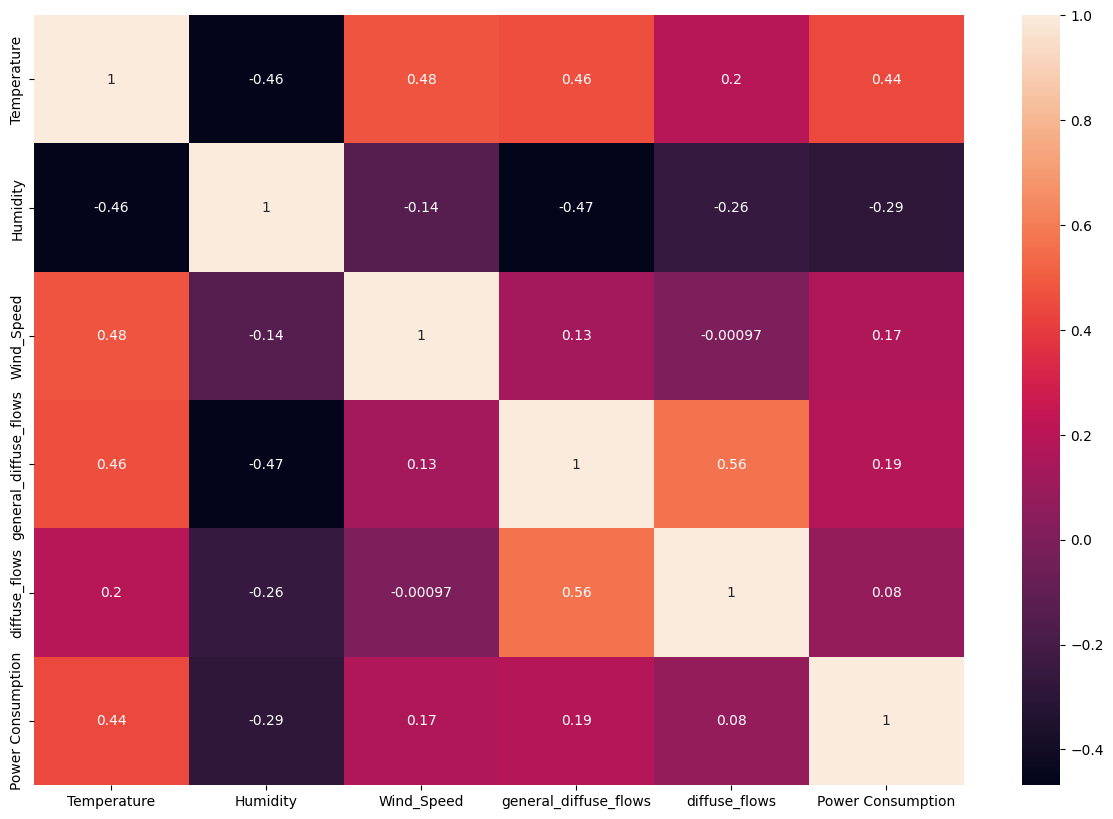

In [8]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True)
plt.show()


In [9]:
# Apply MinMaxScaler to scale the features
scaler_features = MinMaxScaler()
df_scaled_features = scaler_features.fit_transform(df.drop(['Power Consumption'], axis=1))

# Scale the target variable separately
scaler_target = MinMaxScaler()
df_scaled_target = scaler_target.fit_transform(df[['Power Consumption']])

In [10]:
# Concatenate scaled features and target into one DataFrame
df_scaled = np.concatenate([df_scaled_features, df_scaled_target], axis=1)

# Split the data into train and test sets
train_size = int(len(df) * 0.8)
train_scaled, test_scaled = df_scaled[:train_size], df_scaled[train_size:]

In [11]:
# Convert data to appropriate shape for BiLSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 5

X_train_scaled, y_train_scaled = create_dataset(train_scaled[:, :-1], train_scaled[:, -1], TIME_STEPS)
X_test_scaled, y_test_scaled = create_dataset(test_scaled[:, :-1], test_scaled[:, -1], TIME_STEPS)

In [23]:
print(X_train_scaled.shape)
print(y_train_scaled.shape)
print(X_test_scaled.shape)
print(y_test_scaled.shape)

(41927, 5, 5)
(41927,)
(10479, 5, 5)
(10479,)


In [30]:
# Define the model
model = Sequential()

# CNN layers
model.add(Conv1D(filters=64,kernel_size=3,padding='same',activation='relu',input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv1D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Stacked BiLSTM layers
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256)))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



In [31]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 5, 64)             1024      
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 2, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_35 (Conv1D)          (None, 2, 128)            24704     
                                                                 
 conv1d_36 (Conv1D)          (None, 2, 256)            98560     
                                                                 
 max_pooling1d_26 (MaxPooli  (None, 1, 256)            0         
 ng1D)                                                           
                                                                 
 bidirectional_18 (Bidirect  (None, 1, 512)          

In [32]:
# Train the model
model.fit(X_train_scaled,y_train_scaled,batch_size=64, epochs=64, verbose=1)

Epoch 1/64
656/656 [==============================] - 55s 69ms/step - loss: 0.0269
Epoch 2/64
656/656 [==============================] - 45s 68ms/step - loss: 0.0216
Epoch 3/64
656/656 [==============================] - 45s 69ms/step - loss: 0.0204
Epoch 4/64
656/656 [==============================] - 45s 68ms/step - loss: 0.0194
Epoch 5/64
656/656 [==============================] - 45s 68ms/step - loss: 0.0189
Epoch 6/64
656/656 [==============================] - 45s 68ms/step - loss: 0.0184
Epoch 7/64
656/656 [==============================] - 45s 68ms/step - loss: 0.0180
Epoch 8/64
656/656 [==============================] - 45s 68ms/step - loss: 0.0176
Epoch 9/64
656/656 [==============================] - 45s 68ms/step - loss: 0.0174
Epoch 10/64
656/656 [==============================] - 45s 69ms/step - loss: 0.0171
Epoch 11/64
656/656 [==============================] - 45s 69ms/step - loss: 0.0170
Epoch 12/64
656/656 [==============================] - 45s 69ms/step - loss: 0.0168
E

In [33]:
y_pred_scaled = model.predict(X_test_scaled)

328/328 [==============================] - 6s 12ms/step


In [34]:
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_test = scaler_target.inverse_transform(y_test_scaled.reshape(-1, 1))

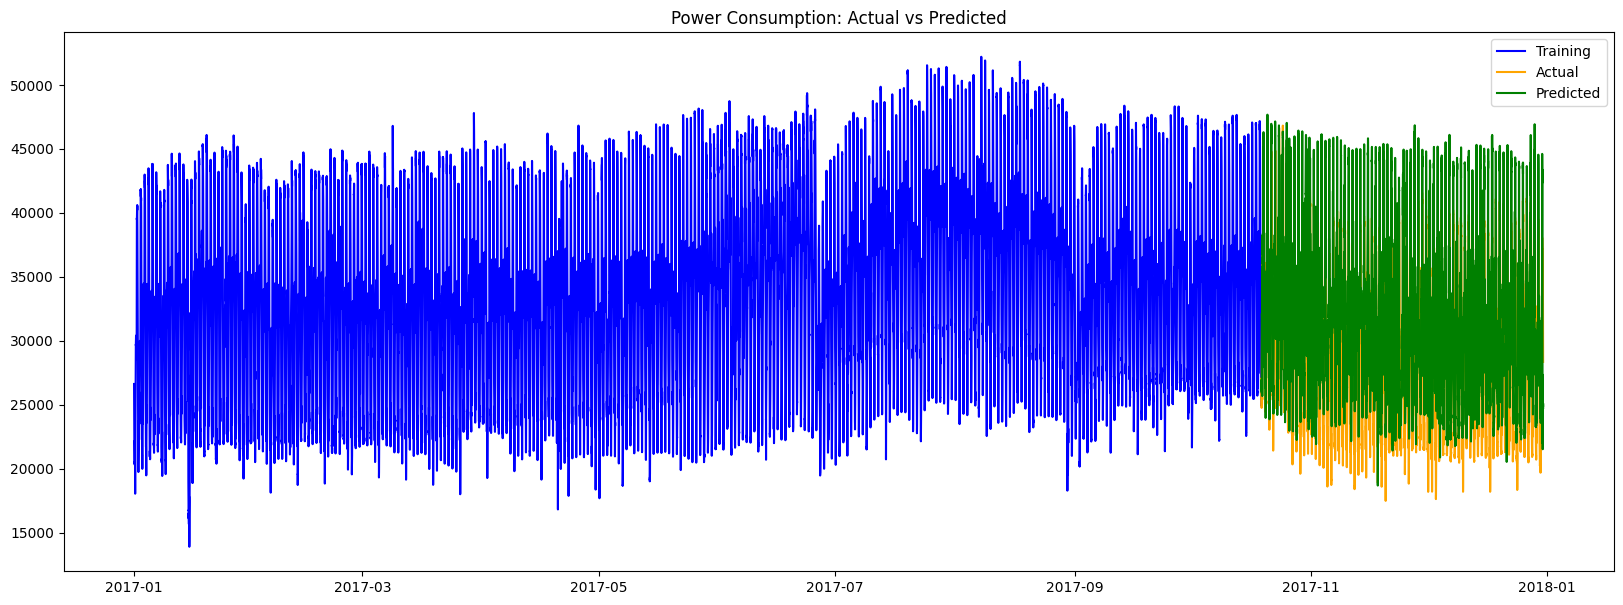

In [38]:

plt.figure(figsize=(20, 7))
plt.plot(df.index[:len(y_train_scaled.reshape(-1, 1))], scaler_target.inverse_transform(y_train_scaled.reshape(-1, 1)), color='blue', label='Training')
plt.plot(df.index[len(y_train_scaled):len(y_train_scaled)+len(y_test)], y_test, color='orange', label='Actual')
plt.plot(df.index[len(y_train_scaled):len(y_train_scaled)+len(y_test)], y_pred, color='green', label='Predicted')
plt.title('Power Consumption: Actual vs Predicted')
plt.legend()
plt.show()


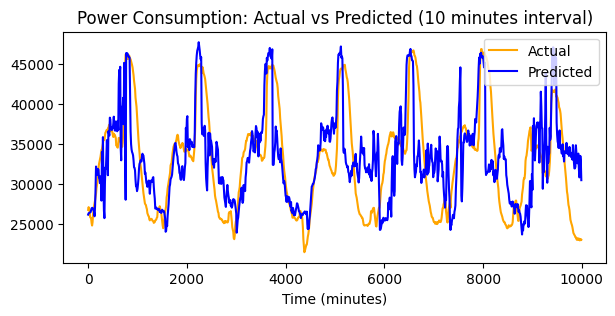

In [58]:

# Define the start and end indices for the 10000-second interval
start_index = df.index.get_loc(pd.to_datetime('2017-01-01 00:00:00'))
end_index = start_index + int(10000 / 10)  # Each step is 10 minutes

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(7, 3))

# Plot the data
ax.plot(np.arange(0, end_index-start_index)*10, y_test[start_index:end_index], color='orange', label='Actual')
ax.plot(np.arange(0, end_index-start_index)*10, y_pred[start_index:end_index], color='blue', label='Predicted')

# Set the title and legend
ax.set_title('Power Consumption: Actual vs Predicted (10 minutes interval)')
ax.legend()

# Set the x-axis label to 'Time (minutes)'
ax.set_xlabel('Time (minutes)')

plt.show()
